![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [785]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
import itertools
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/positive-words/positive-words.txt


In [786]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [787]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# FUNCTIONS

In [788]:
# Функция для поиска дубликатов в колонке (1- есть дубликат, 0 - нет дубликата) 
def dup_col(col):
    duplicated_col = col.value_counts().loc[lambda x: x>1].index.tolist()
    new_col = []
    for x in col:
        if x in duplicated_col:
            new_col.append(1)
        else:
            new_col.append(0)
    return new_col

# Функция для убирания пропусков у 'Number of Reviews'
def mean_per_city_fillna(var_name, tednention):
    '''The function takes variable name
    create variable with mean per city values of var_name,
    fill na-values in [var_name],
    and create new variable fillna_tednention_var_name'''
    
    if tednention == "mean":
        # среднее количество переменной по городу
        mean_var_name_per_city = data.groupby('City')[var_name].mean()
    elif tednention == "median":
        mean_var_name_per_city = data.groupby('City')[var_name].median()
    data[f'{tednention}_{var_name}_per_city'] = data.City.apply(
    lambda x: round(mean_var_name_per_city.loc[x]))
    # заполнением nan средним по городу
    df = data.copy()
    df.index = df.City
    values = {key:value for key in set(df.index) 
              for value in set(df[f'{tednention}_{var_name}_per_city'])}
    df[var_name].fillna(value=values, inplace=True, axis=0)
    # перезапишем значения переменной var_name в data
    data[f'fillna_{tednention}_{var_name}'] = list(df[var_name])
    
# Функция для подсчета разницы между двумя датами
def find_days(d):
    ln_d = len(d)
    if ln_d >1:
        new_d = sorted(d)
        ans = (new_d[ln_d-1]-new_d[ln_d-2]).days
        return ans

# Функция отображение гистограмы, границ IQR и выбросов

# tit - hist title
# rhb - reviewed highest border in 'Здравый смысл'
# rlb - reviewed lowest border in 'Здравый смысл'
# one of rhb or rlb could be missed

def hist_check(dth, b, tit, rhb=None, rlb=None):
    IQR = dth.quantile(0.75) - dth.quantile(0.25)
    perc25 = dth.quantile(0.25)
    perc75 = dth.quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))

    fig = plt.figure()
    dth.loc[dth.between(
        lb,
        hb)].hist(bins=b, label='IQR')

    if rlb != None and rhb != None:
        dth.loc[(rlb <= dth) & (dth <= rhb)].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rlb) and rhb != None:
        dth.loc[dth <= rhb].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rhb) and rlb != None:
        dth.loc[rlb <= dth].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')

    plt.legend()
    plt.title(tit)
    return [lb, hb]

def get_Weighed_Rank_RK(row):
    '''
    Вычисляем относительную позицию ресторана среди всех ресторанов города
    '''
    Weighed_Rank = row['Ranking'] / row['Amount Rest']

    return Weighed_Rank

def get_Weighed_Rank(row):
    i=0
    city_min = CityMinMax[CityMinMax['City'] == row.City ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['City'] == row.City ]['max'].iloc[0]
    Weighed_Rank = round(1-(row['Ranking'] - city_min)/(city_max - city_min),3)
    #print('<---',Weighed_Rank,'--->')
    return Weighed_Rank

def get_cuisines(cuisines):
    '''
    Получаем список кухонь в виде:
    cuisines[0] - list of cusines
    если был NaN, то возвращается 'Regionl Cusine' -как самая популярная в регионе/городе/стране
    '''
    if cuisines == 'NaN': return ['Regionl Cusine']#['Vegetarian Friendly'] # 'Vegetarian Friendly' - самая популярная
    if  cuisines:
        cuisines = str(cuisines).replace("'",'"')
        return json.loads(cuisines)
    else:
        return ['Regionl Cusine'] #return ['Vegetarian Friendly']

allCusines = []
def cuisine_styles_count(row):
    '''
    Получаем количество кухонь
    '''
    global allCusines
    cusines = get_cuisines(row['Cuisine Style'])
    
    if row['Cuisine Style'] != 'NaN':    
        cusines = get_cuisines(row['Cuisine Style'])
        allCusines.extend(cusines)
        cuisines_count =len(cusines)
    else:
        cuisines_count = 1

    return cuisines_count

def is_cuisine_top_N(cs):
    '''
    Возвращаем список кухонь, входящих в основной список кухонь,для остальных Other
    '''
    c = get_cuisines(cs)
    c = set(c)

    shared_cousines=()
    shared_cousines=c.intersection(topNcusines)

    if len(shared_cousines) != len(c):
        shared_cousines = list(shared_cousines)
        shared_cousines.extend(['Other'])

    return list(shared_cousines)

# DATA

In [789]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [790]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [791]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [792]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [793]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [794]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [795]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [796]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [797]:
data['ID_TA']

0        d10746918
1         d6674944
2        d13129638
3          d680417
4         d1112354
           ...    
49995     d2104414
49996     d1800036
49997      d947615
49998     d1100838
49999     d1109020
Name: ID_TA, Length: 50000, dtype: object

In [798]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: x[1:]) 

In [799]:
data['ID_TA']

0        10746918
1         6674944
2        13129638
3          680417
4         1112354
           ...   
49995     2104414
49996     1800036
49997      947615
49998     1100838
49999     1109020
Name: ID_TA, Length: 50000, dtype: object

In [800]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [801]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
47235,id_5046,Berlin,NaN,5048.0,NaN,NaN,"[['Kebab and chicken shop - tasty.'], ['06/01/...",/Restaurant_Review-g187323-d5531945-Reviews-Do...,5531945,1,4.0
38155,id_1476,Copenhagen,NaN,1479.0,NaN,3.0,"[['Porridge with interesting toppings!'], ['01...",/Restaurant_Review-g189541-d11997772-Reviews-G...,11997772,1,3.5
13082,id_1665,Copenhagen,NaN,1669.0,NaN,8.0,"[['Very Good Thai Food Take Out', 'Full of fla...",/Restaurant_Review-g189541-d11965418-Reviews-R...,11965418,1,3.5
13829,id_5372,Barcelona,"['Mexican', 'Mediterranean']",5373.0,NaN,6.0,"[['Great Mexican food'], ['01/06/2018']]",/Restaurant_Review-g187497-d12741799-Reviews-Z...,12741799,1,5.0
29405,id_13749,London,"['Asian', 'Indian']",13759.0,NaN,11.0,"[['2nd visit and last', 'A bit rough round the...",/Restaurant_Review-g186338-d4374942-Reviews-Be...,4374942,1,4.0


In [802]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [803]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [804]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [805]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [806]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [807]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [808]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [809]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
38875,id_1102,"['Thai', 'Vietnamese']",1104.0,$,15.0,"[['A great surprise!', 'Nice food'], ['05/02/2...",/Restaurant_Review-g187331-d6872103-Reviews-No...,6872103,1,4.0,...,0,0,0,0,0,0,0,0,0,0
42851,id_4047,NaN,4049.0,NaN,20.0,"[['Great bar for drinks or dancing', 'Not for ...",/Restaurant_Review-g187323-d942119-Reviews-Aug...,942119,1,4.0,...,0,0,0,0,0,0,0,0,0,0
41943,id_10365,['French'],10367.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d3606073-Reviews-Fe...,3606073,1,4.5,...,0,0,1,0,0,0,0,0,0,0
10554,id_400,"['Vegetarian Friendly', 'Gluten Free Options']",401.0,$$$$,1084.0,"[['Beautiful cuisine', 'Set lunch'], ['01/08/2...",/Restaurant_Review-g186338-d1029286-Reviews-Th...,1029286,1,4.5,...,0,0,0,0,0,0,0,0,0,0
13446,id_2011,['French'],2012.0,$$ - $$$,95.0,"[['Real little gem', 'A great French cafe'], [...",/Restaurant_Review-g187147-d7687657-Reviews-Jo...,7687657,1,4.5,...,0,0,1,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [810]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [811]:
# Ваша обработка 'Price Range'

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [812]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

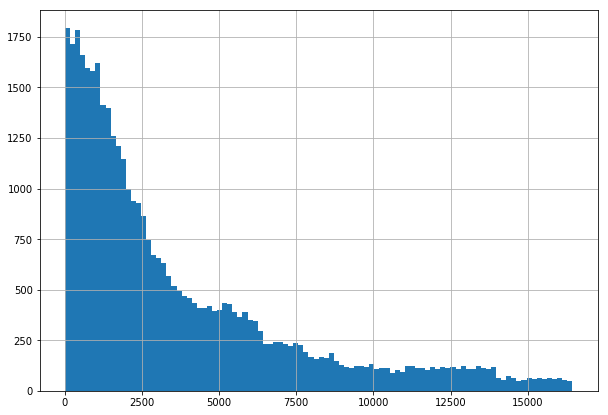

In [813]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

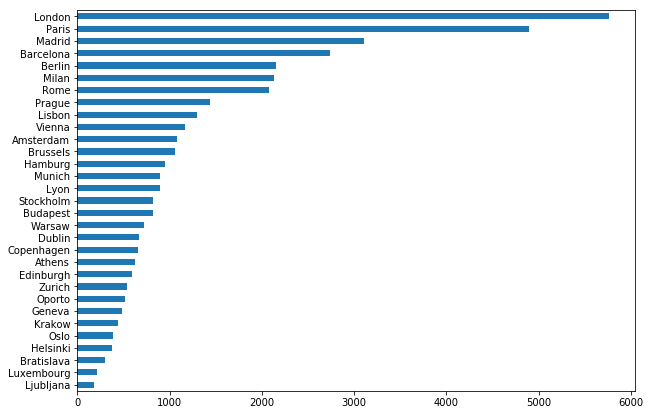

In [814]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

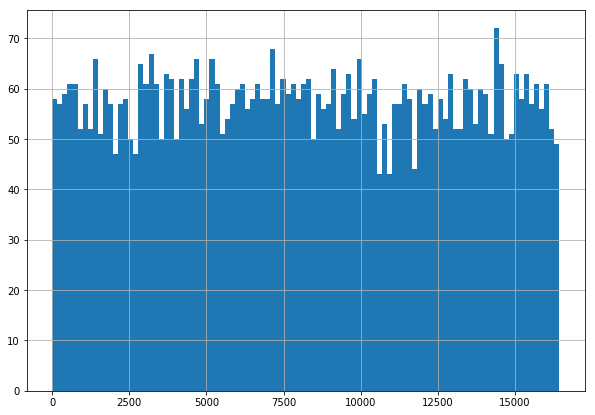

In [815]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

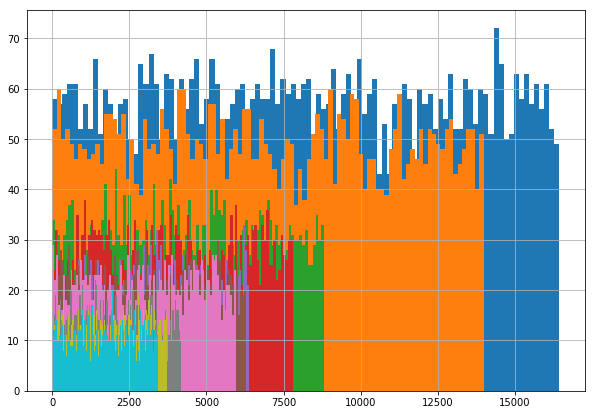

In [816]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

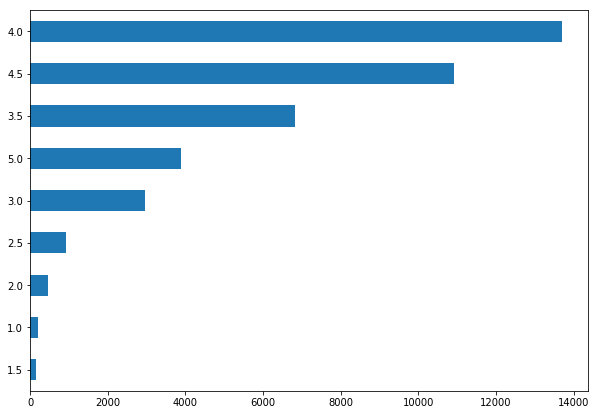

In [817]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

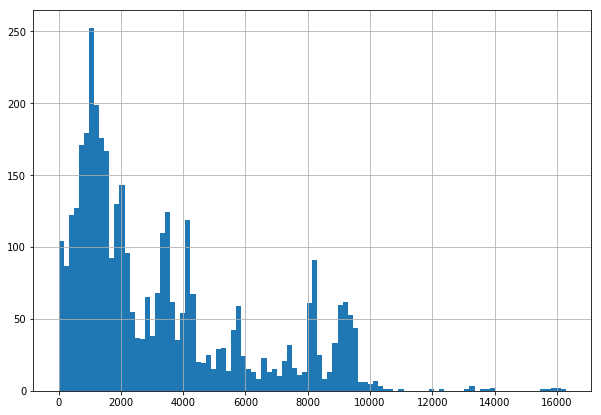

In [818]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

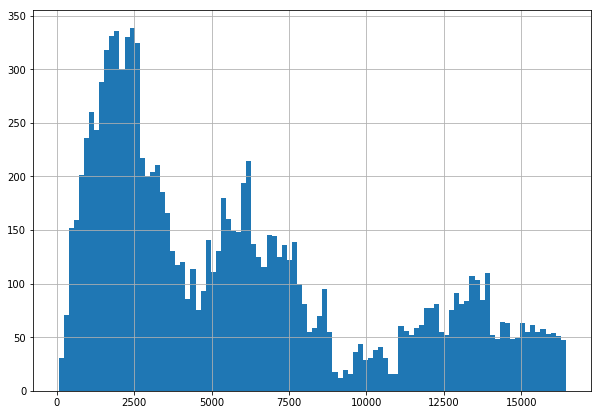

In [819]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

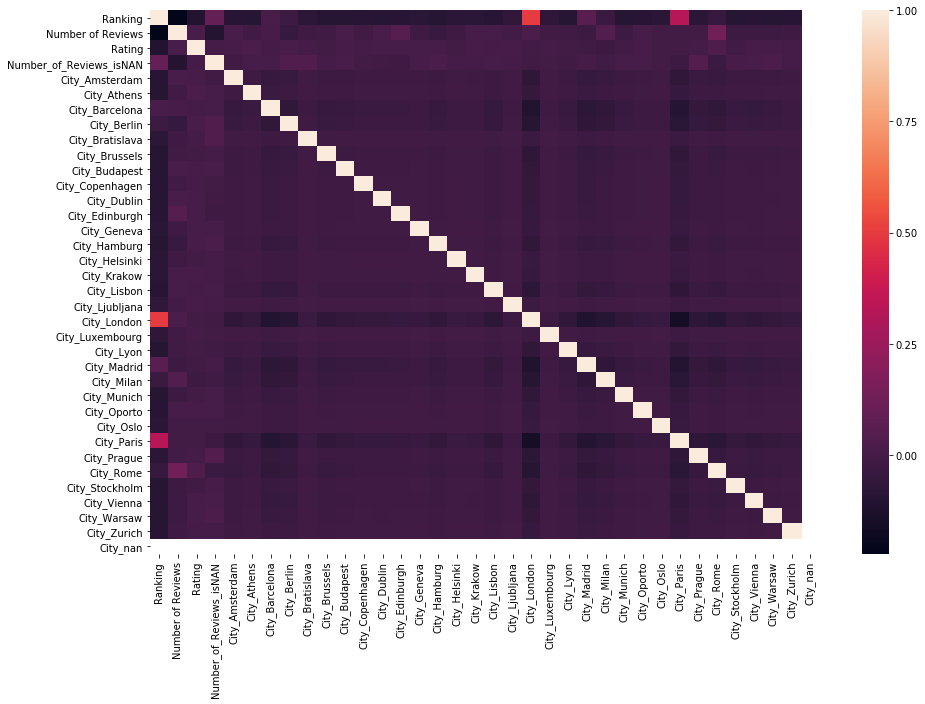

In [820]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [821]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [822]:
# Создаем признак общего количества ресторанов в городе
amount = data['City'].value_counts().to_dict()
data['Amount Rest'] = data.City.apply(lambda x: amount[x])

# # Либо так
# restorants_in_city = data.groupby('City')['Ranking'].count().to_dict()
# data['Restaurants Count'] = data['City'].map(restorants_in_city)

****Price Range****

In [823]:
# Создаем признак с 'Price Range NAN'. Перекодируем 'Price Range'
data['New_Price_Range'] = data['Price Range'].map({'$$ - $$$':2, '$':1, '$$$$':3})

# или так:
# cleanup_nums = {'Price Range':     {"$": 1, "$$ - $$$": 2, "$$$$": 3, np.NaN: 2}} # чаще всего встречается "$$ - $$$" == 2
# data['Price Range NAN'] = data['Price Range'].isna()
# data.replace(cleanup_nums, inplace=True)

In [824]:
# Убираем NAN в 'New_Price_Range'
data['New_Price_Range'] = data.groupby("City")['New_Price_Range']\
                            .transform(lambda x: x.fillna(round(x.mean()))).astype(int)

****ID_TA****

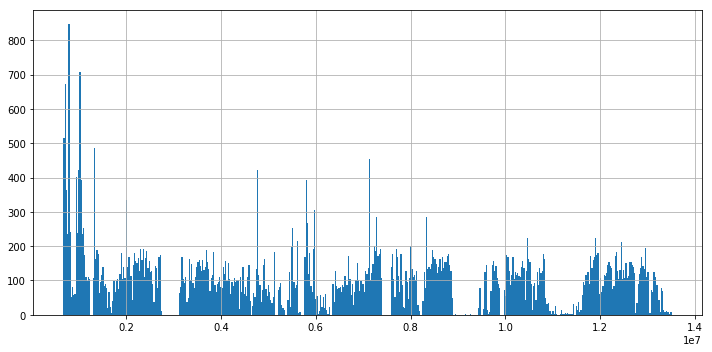

In [825]:
# Посмотрим на 'ID_TA'
data['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(10, 5), bins=500);
plt.tight_layout()
# Видно Несколько групп - на ID - точно не похоже. 

In [826]:
# Убираем буквы с ID для дальнейшего преобраования в Инт
data['ID_TA'] = data['ID_TA'].apply(lambda x: x[1:])
data['ID_TA'] = data['ID_TA'].astype(int)

In [827]:
# Создаем create column with id_ta which has duplicates 
data['ID_TA_dublicates'] = dup_col(data.ID_TA)

In [828]:
# Посчитаем длину кода 'ID_TA' - worse mae
#data['ID_TA'] = data.ID_TA.apply(lambda x: len(x[1:]))

**Number of Reviews**

In [829]:
# Создаем признак 'Number of Reviews NAN' и убираем пропуски с 'Number of Reviews'
data['Number of Reviews NAN'] = data['Number of Reviews'].isna()
mean_per_city_fillna('Number of Reviews', 'mean')
data['Number of Reviews'] = data['Number of Reviews'].fillna(data['fillna_mean_Number of Reviews'])
data = data.drop(['fillna_mean_Number of Reviews'], axis=1)

In [830]:
# Или так:
# data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
# data["Number of Reviews"] = data.groupby("City")['Number of Reviews']\
# .transform(lambda x: x.fillna(round(x.mean())))

In [831]:
# Создание признака с датами 'Review_date'
pat = re.compile('\'\d+\/\d+\/\d+\'?')
data['Review_date'] = data.Reviews\
                    .apply(lambda x: [] if pd.isna(x) else re.findall(pat,x) )\
                    .apply(lambda y:[pd.to_datetime(item) for item in y ])

In [832]:
# Подсчет разницы между двумя датами и создание признака 'Review_date_dif'
data['Review_date_dif'] = data.Review_date.apply(lambda x: find_days(x))

In [833]:
# Содание признака Review_date_dif   
data['Review_date_dif_isNAN'] = pd.isna(data['Review_date_dif']).astype('uint8')

In [834]:
# Заполним пропуски в 'Review_date_dif'
data['Review_date_dif'] = data.fillna(data['Review_date_dif'].median())

In [835]:
# # Посмотрим на Review_date_dif
# col_name = 'Review_date_dif'
# bord = hist_check(data[col_name], 17, tit=col_name, rhb = 3000)

In [836]:
# from sklearn.preprocessing import LabelEncoder

# # Не будем кодировать названия городов - get_dummies справится 
# data["City"] = data["City"].astype('category')
# #data["City"] = data["City"].cat.codes
# encoder = LabelEncoder()
# data['City'] = encoder.fit_transform(data['City'])

**Ranking**

In [837]:
data['Weighed Rank'] = data.apply(lambda x: get_Weighed_Rank_RK(x), axis=1)

In [838]:
CityMinMax = data.groupby('City')['Ranking'].agg([min,max])
CityMinMax = CityMinMax.reset_index()
data['Weighed Rank min max'] = data.apply(lambda x: get_Weighed_Rank(x), axis=1)

**Cuisine Style**

In [839]:
# Посмотрим на самые распостраненные кухни
data['Cuisine Style'].explode().value_counts(ascending=False)

['Italian']                                                                                               1332
['French']                                                                                                1019
['Spanish']                                                                                                860
['French', 'European']                                                                                     503
['Cafe']                                                                                                   500
                                                                                                          ... 
['Cafe', 'Contemporary', 'Healthy', 'Soups']                                                                 1
['Cajun & Creole', 'Pizza']                                                                                  1
['Brazilian', 'Cafe', 'European', 'Portuguese', 'South American']                                            1
[

In [840]:
# # Преобразуем строку с названиями кухонь в список [list] названий кухонь.
# # На входе - строковая переменная, содержащая названия кухонь.
# # На выходе - список [list] названий кухонь.
# data['Cuisine Style'] = data['Cuisine Style'].apply(
#     lambda x:  np.nan if pd.isna(x) else str(x).strip(
#     '[]').replace("'","").split(", "))

In [841]:
# Получаем Cuisines Count, самую популярную кухню, среднее к-во кухонь в ресторане и устраняем NaN
data['Cuisine Style'] = data['Cuisine Style'].fillna('NaN')
data['Cuisines Count'] = data.apply(cuisine_styles_count, axis=1)
# или так data['Cuisines Count'] = data['Cuisine Style']\
#                                 .apply(lambda x: 1 if type(x)==float and pd.isna(x)  else len(x))

most_popular_cusine = pd.Series(allCusines).value_counts().index[0]
average_cousines_count = np.round(data['Cuisines Count'].mean())

In [842]:
# Узнаем сколько кухонь представлено в городе каждого ресторана
cusines_in_city={}
cusines_count_in_city={}
for city_name, group in data.groupby('City'):

    cusines = group['Cuisine Style'].apply(get_cuisines)
   
    cusines_list = list(itertools.chain.from_iterable(cusines))
    #cusines_list = [x for x in cusines_list if x != 'Vegetarian Friendly'] # удаляем 'Vegetarian Friendly' - она "забивает" все результаты
    cusines_in_city[city_name] = Counter(cusines_list)

for city_name in cusines_in_city.keys():
    cusines_count_in_city[city_name] = len(cusines_in_city[city_name])

data['Cusines Count In City'] = data['City'].map(cusines_count_in_city)

In [843]:
# Создадим перемуннею взмешеного значения между 
# количеством кухонь представленых в ресторане и в городе
data['Weighed Cuisines Count'] = data['Cuisines Count'] / data['Cusines Count In City']

In [844]:
# Создадим признак самой популярной кухни к городе в котором находится ресторан для дальнейшего шага
data['Most Common Cusine in City'] = data['City'].apply(
    lambda x: cusines_in_city[x].most_common(1)[0][0])

In [845]:
# Создадим признак 'Cuisine Style NAN', и заполнение NAN значений 
data['Cuisine Style NAN'] = data['Cuisine Style'].isna()
data['Cuisine Style'] = data.apply(
    lambda x: x['Cuisine Style'] if x['Cuisine Style NAN'] == False else [x['Most Common Cusine in City']], axis=1)

In [846]:
# Создадим признак с определением наличия самой популярной кухни в ресторане
data['isMostPopCusine'] = data['Cuisine Style'].apply(lambda x: 1 if most_popular_cusine in x else 0 )

In [847]:
# Можно еще создать признак с определением наличия в ресторане кухни c количеством 1-2
data['isMultyCusine'] = data['Cuisines Count'].apply(lambda x: 1 if  x >= average_cousines_count else 0 )

In [848]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
N=30 #!!!

s = data['Cuisine Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
data['Cuisine top N'] = data['Cuisine Style'].apply(lambda x: is_cuisine_top_N(x))

**Price_Range**

In [849]:
# Создадим еще такой признакзависимости цены от ранга ресторана
data['Relative Price Range'] = data['New_Price_Range'] / data['Weighed Rank']

In [850]:
# Средняя цена в городе
price_in_city_dict = data.groupby('City')['New_Price_Range'].mean().to_dict()
data['Price in City'] = data['City'].map(price_in_city_dict)

**Restaurant_net_id**

In [851]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
import warnings; warnings.simplefilter('ignore')
data['Restaurant_net_id'] = data['Restaurant_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = data[data['Restaurant_net_id'].isin(data['Restaurant_net_id'].value_counts()[data['Restaurant_net_id'].value_counts()>2].index)]
NetworkRestorants['isNetworkRestorant'] = True
data['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
data['isNetworkRestorant'] = data['isNetworkRestorant'].fillna(False)

In [852]:
# # Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other.
# top_Cities = data['City'].value_counts()[0:10].index.to_list()
# data['TopCities'] = data.City.apply(lambda x: x if x in top_Cities else 'Other_City')

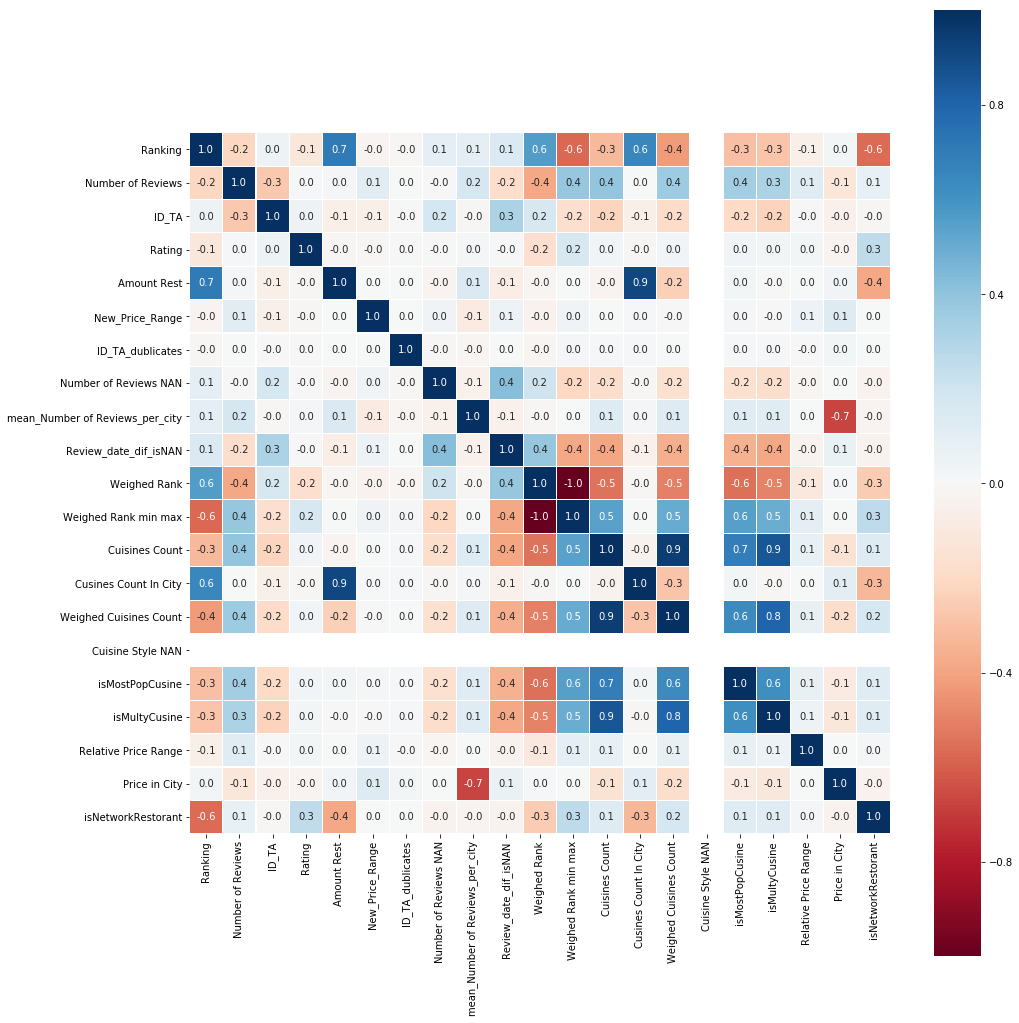

In [853]:
# Посмотрим график корреляции с помощью heatmap до 
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data.drop(['sample'], axis=1).corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Быстрый способ получить из строки список:
data['cuisine'] = data['cuisine'].apply(lambda x: eval(x))

In [854]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [855]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,ID_TA,sample,Rating,Amount Rest,New_Price_Range,ID_TA_dublicates,Number of Reviews NAN,mean_Number of Reviews_per_city,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
17120,1332.0,4.0,10110449,1,5.0,1126,2,0,False,87.0,...,0,0,0,0,0,0,0,0,0,0
20489,5770.0,7.0,10153898,1,3.0,2694,2,0,False,168.0,...,0,0,0,0,0,0,0,0,0,0
40231,352.0,136.0,4891277,1,4.5,836,2,0,False,154.0,...,0,0,0,0,0,0,0,0,0,0
35464,1353.0,77.0,6987539,1,4.5,2705,2,0,False,64.0,...,0,0,0,0,0,0,0,0,0,0
3122,1095.0,69.0,804034,0,0.0,1647,2,0,False,128.0,...,0,0,0,0,0,0,0,0,0,0
7918,3409.0,20.0,1084005,0,0.0,3395,2,0,False,136.0,...,0,0,0,0,0,0,0,0,0,0
10025,1077.0,2.0,12018194,1,5.0,925,1,0,False,67.0,...,0,0,0,0,0,0,0,1,0,0
13926,1374.0,86.0,12153499,1,4.0,3813,2,0,False,100.0,...,0,0,0,0,0,0,0,0,0,0
46476,973.0,23.0,808091,1,3.0,475,2,0,False,66.0,...,0,0,0,0,0,0,0,0,0,0
40125,141.0,148.0,743814,1,4.0,263,2,0,False,83.0,...,0,0,0,0,0,0,0,0,0,0


In [856]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
Ranking                            50000 non-null float64
Number of Reviews                  50000 non-null float64
ID_TA                              50000 non-null int64
sample                             50000 non-null int64
Rating                             50000 non-null float64
Amount Rest                        50000 non-null int64
New_Price_Range                    50000 non-null int64
ID_TA_dublicates                   50000 non-null int64
Number of Reviews NAN              50000 non-null bool
mean_Number of Reviews_per_city    50000 non-null float64
Review_date_dif_isNAN              50000 non-null uint8
Weighed Rank                       50000 non-null float64
Weighed Rank min max               50000 non-null float64
Cuisines Count                     50000 non-null int64
Cusines Count In City              50000 non-null int64
Weighed Cuisines Count             50000

In [857]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [858]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [859]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 53), (40000, 53), (40000, 52), (32000, 52), (8000, 52))

# Model 
Сам ML

In [860]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [861]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [862]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [863]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19839937499999996


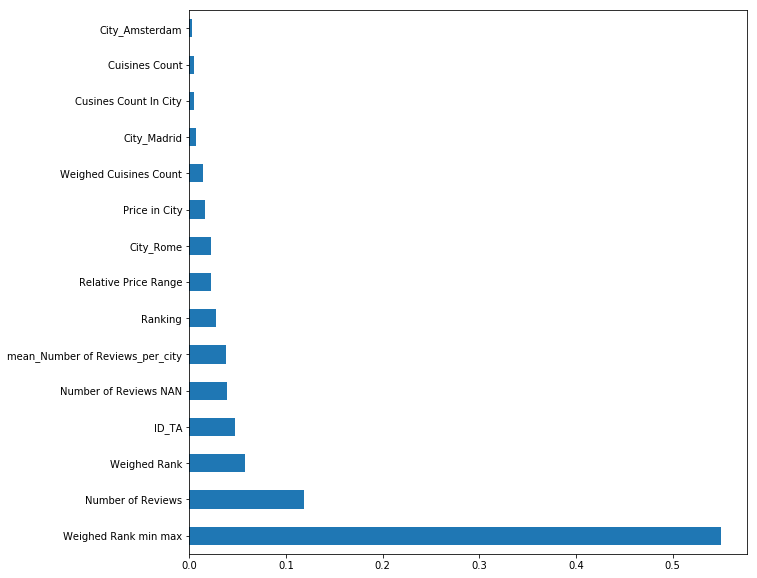

In [864]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [865]:
test_data.sample(10)

,Ranking,Number of Reviews,ID_TA,Rating,Amount Rest,New_Price_Range,ID_TA_dublicates,Number of Reviews NAN,mean_Number of Reviews_per_city,Review_date_dif_isNAN,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
3370,5468.0,81.0,2278252,0.0,6108,2,0,False,117.0,0,...,0,0,1,0,0,0,0,0,0,0
2638,4605.0,326.0,2051778,0.0,7193,2,0,False,138.0,0,...,0,0,0,0,0,0,0,0,0,0
3046,4042.0,84.0,2430067,0.0,6108,2,0,False,117.0,0,...,0,0,1,0,0,0,0,0,0,0
2008,1046.0,52.0,7934212,0.0,745,1,0,False,238.0,0,...,0,0,0,0,0,0,0,0,0,0
9223,10781.0,124.0,13101885,0.0,6108,2,0,True,117.0,1,...,0,0,1,0,0,0,0,0,0,0
3067,2378.0,24.0,5889271,0.0,1372,2,0,False,149.0,0,...,0,0,0,0,0,0,0,0,0,0
3480,1868.0,185.0,3359968,0.0,6108,2,0,False,117.0,0,...,0,0,1,0,0,0,0,0,0,0
8740,301.0,324.0,4355271,0.0,3395,2,0,False,136.0,0,...,0,0,0,0,0,0,0,0,0,0
181,7219.0,14.0,6767680,0.0,7193,2,0,False,138.0,0,...,0,0,0,0,0,0,0,0,0,0
6730,629.0,220.0,2689394,0.0,2694,2,0,False,168.0,1,...,0,0,0,0,0,0,0,0,0,0


In [866]:
test_data = test_data.drop(['Rating'], axis=1)

In [867]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [868]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [869]:
predict_submission

array([3.085, 4.195, 4.535, ..., 3.045, 4.495, 4.17 ])

In [870]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.085
1,id_1,4.195
2,id_2,4.535
3,id_3,4.330
4,id_4,4.455
5,id_5,4.555
6,id_6,1.410
7,id_7,3.265
8,id_8,4.130
9,id_9,4.585


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
